<a href="https://colab.research.google.com/github/Jiayi1827/CS-446/blob/main/Xiao_proj5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project #5: Video Stitching and Processing

## CS445: Computational Photography - Spring 2024

### Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/CS445/Project5')

In [ ]:
# modify to where you store your project data including utils
datadir = "/content/drive/MyDrive/CS445/Project5/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
imagesfn = datadir + "images"
!cp -r "$imagesfn" .

In [ ]:
import os
os.sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/CS445/Project5']

In [ ]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 23.7 MB/s eta 0:00:00


In [ ]:
!pip install opencv-contrib-python


In [ ]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit to use SIFT
!pip install opencv-contrib-python --force-reinstall
!pip install ffmpeg-python # for converting to video

import ffmpeg
import numpy as np
import os
from numpy.linalg import svd, inv
%matplotlib inline
from matplotlib import pyplot as plt

Found existing installation: opencv-python 4.9.0.80
Uninstalling opencv-python-4.9.0.80:
  Successfully uninstalled opencv-python-4.9.0.80
  Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (68.3 MB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.9.0.80
    Uninstalling opencv-contrib-python-4.9.0.80:
      Successfully uninstalled opencv-contrib-python-4.9.0.80
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.6 requires opencv-python>=3.4.8.29, which is not installed.
imgaug 0.4.0 requires opencv

In [ ]:
import ffmpeg
import cv2
import numpy as np
import os
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

### Part I: Stitch two key frames

#### This involves:
1. compute homography H between two frames;
2. project each frame onto the same surface;
3. blend the surfaces.

Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image.

In [ ]:
def score_projection(pt1, pt2):
    '''
    Score corresponding to the number of inliers for RANSAC
    Input: pt1 and pt2 are 2xN arrays of N points such that pt1[:, i] and pt2[:,i] should be close in Euclidean distance if they are inliers
    Outputs: score (scalar count of inliers) and inliers (1xN logical array)
    '''

    threshold = 4
    dist = np.sqrt(np.sum((pt1 - pt2)**2, axis=0))  # Euclidean distances
    inliers = dist < threshold
    score = np.sum(inliers)
    return score, inliers

def auto_homography(Ia,Ib, homography_func=None,normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)

    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)

    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))

    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0
    n_to_sample = 4 # Put the correct number of points here   # coz need 4 corresponding point pairs to estimate a homography matrix

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, n_to_sample, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]

        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (computeHomography)


        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H

        score_t, inliers_t = score_projection(Xb[:2,:]/Xb[2,:], Xb_[:2,:]/Xb_[2,:])

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = inliers_t

    print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

In [ ]:
def computeHomography(pts1, pts2, normalization_func=None):
    """
    Compute homography that maps from pts1 to pts2 using SVD.
    Normalization is optional.
    Input:
        pts1 and pts2 are 3xN matrices for N points in homogeneous coordinates.
    Output:
        H is a 3x3 matrix, such that pts2 ~ H * pts1
    """
    N = pts1.shape[1]
    A = []
    for i in range(N):
        x, y, w = pts1[:, i]
        xp, yp, wp = pts2[:, i]
        A.append([-x, -y, -w, 0, 0, 0, x*xp, y*xp, w*xp])
        A.append([0, 0, 0, -x, -y, -w, x*yp, y*yp, w*yp])

    A = np.array(A)

    # Perform SVD on A
    U, S, Vh = np.linalg.svd(A)
    # The solution h is the last column of V (or Vh.T) corresponding to the smallest singular value
    h = Vh.T[:, -1]

    H = h.reshape((3, 3))

    return H

best score: 220.000000
[[ 1.00000000e+00  3.78279053e-02 -2.03423545e+02]
 [ 8.05029749e-03  9.50102412e-01 -1.31461818e+01]
 [ 2.96529498e-04  8.97201870e-06  8.55480103e-01]]


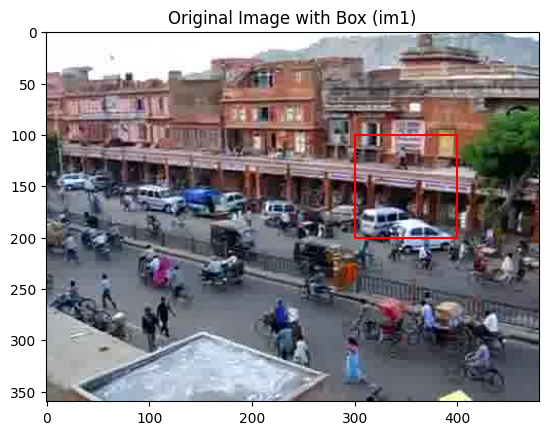

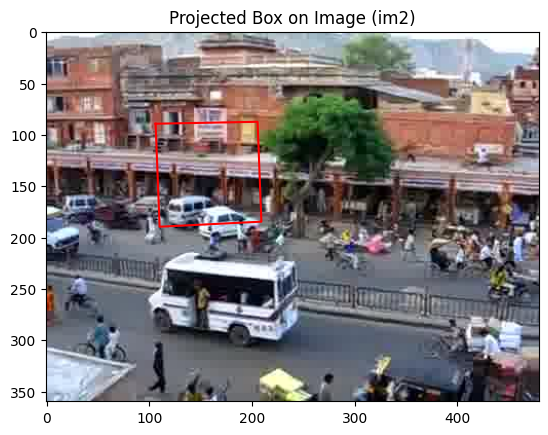

In [ ]:
# images location
im1 = './images/input/frames/f0270.jpg'
im2 = './images/input/frames/f0450.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im2 = cv2.imread(im2)

H = auto_homography(im1,im2, computeHomography)
print(H/H.max())   # Normalize

# plot the frames here
box_pts = np.array([[300, 400, 400, 300, 300], [100, 100, 200, 200, 100], [1, 1, 1, 1, 1]]
                   )
plt.figure()
plt.imshow(im1[:,:,[2,1,0]])
plt.plot(box_pts[0,:], box_pts[1, :], 'r-')
plt.title('Original Image with Box (im1)')

# TO DO: project points into im2 and display the projected lines on im2

# Project the box points to im2 using the homography
projected_pts = np.dot(H, box_pts)
projected_pts = projected_pts / projected_pts[2, :]  # Convert from homogeneous to Cartesian coordinates

plt.figure()
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
plt.plot(projected_pts[0, :], projected_pts[1, :], 'r-')
plt.title('Projected Box on Image (im2)')

plt.show()

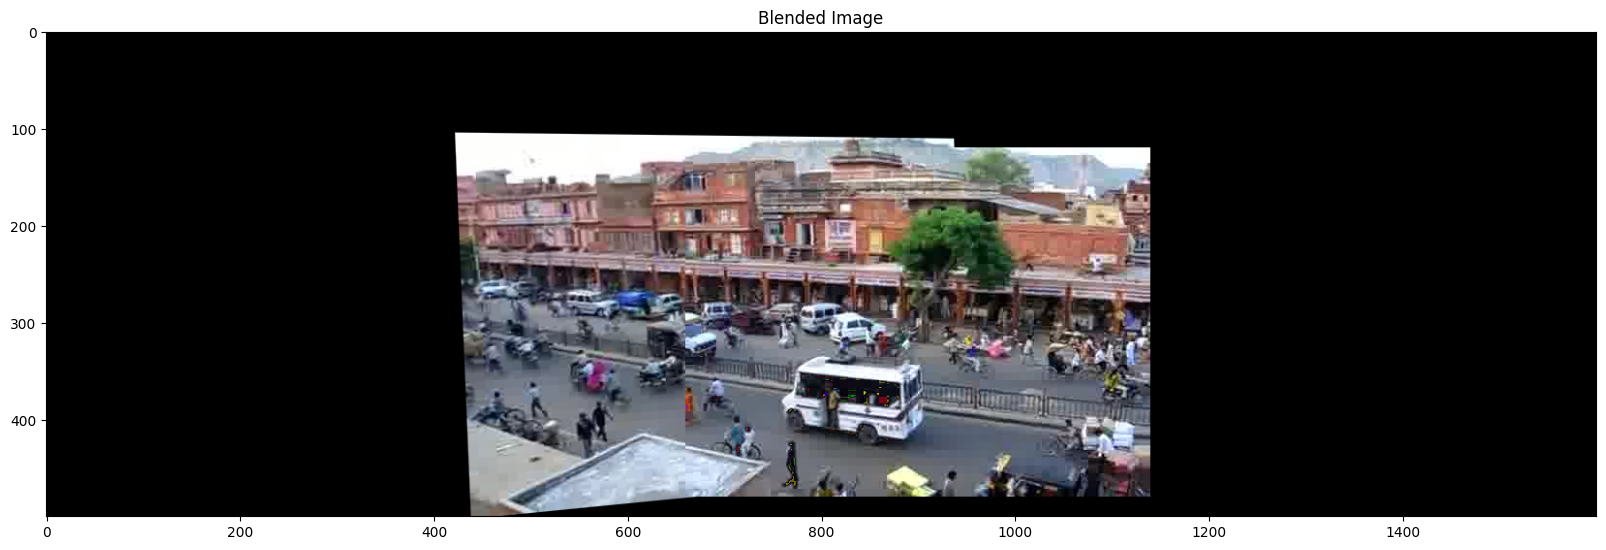

In [ ]:
projectedWidth = 1600
projectedHeight = 500
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]], dtype=np.float32)

# TO DO: warp and blend the two images
# map the frame number 270 onto the reference image (im2)
canvas = np.zeros((projectedHeight, projectedWidth, 3), dtype=np.uint8)

# warp im1 using the homography and the translation
warped_im1 = cv2.warpPerspective(im1, np.dot(Tr, H), (projectedWidth, projectedHeight))

# put im2 on canvas
start_x = 660
start_y = 120
canvas[start_y:start_y + im2.shape[0], start_x:start_x + im2.shape[1]] = im2

#  blending warped_im1 onto the canvas with im2
blended_image = utils.blendImages(warped_im1, canvas)

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.title('Blended Image')
plt.show()


### Part II: Panorama using five key frames

Produce a panorama by mapping five key frames [90, 270, 450, 630, 810] onto the same reference frame 450.  


In [ ]:
key_frames_idx = np.array([90, 270, 450, 630, 810])-1

frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames_idx)):
  frames[n] = cv2.imread("./images/input/frames/f0{num}.jpg".format(num=str(key_frames_idx[n]+1).zfill(3)))

# TO DO solution

In [ ]:
H_to_ref = []

# direct homographies for frames 270 and 630 to the reference frame (frame 450)
H_270_to_450 = auto_homography(frames[1], frames[2], computeHomography)
H_630_to_450 = auto_homography(frames[3], frames[2], computeHomography)


#  two-stage homographies for frames 90 and 810 using frames 270 and 630 respectively
H_90_to_270 = auto_homography(frames[0], frames[1], computeHomography)
H_90_to_450 = np.dot(H_270_to_450, H_90_to_270)

H_810_to_630 = auto_homography(frames[4], frames[3], computeHomography)
H_810_to_450 = np.dot(H_630_to_450, H_810_to_630)


best score: 219.000000
best score: 214.000000
best score: 256.000000
best score: 150.000000


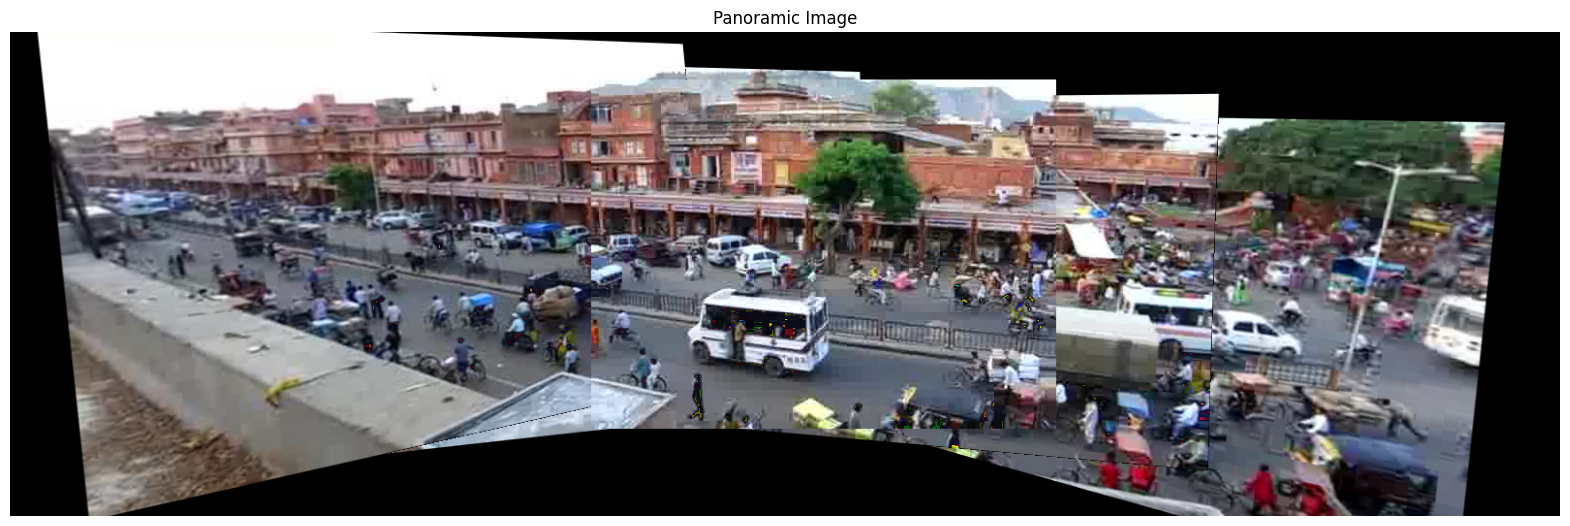

In [ ]:
projectedWidth = 1600
projectedHeight = 500
Tr = np.array([[1, 0, 600], [0, 1, 50], [0, 0, 1]], dtype=np.float32)

canvas = np.zeros((projectedHeight, projectedWidth, 3), dtype=np.uint8)

# Place frame 450 (reference frame) directly onto the canvas without transformation
ref_frame_start_x = 600
ref_frame_start_y = 50
canvas[ref_frame_start_y:ref_frame_start_y + frames[2].shape[0], ref_frame_start_x:ref_frame_start_x + frames[2].shape[1]] = frames[2]


H_to_ref = [H_90_to_450, H_270_to_450, np.eye(3), H_630_to_450, H_810_to_450]  # np.eye(3) for frame 450 itself

# Warp and blend other frames
for idx, frame in enumerate(frames):
    # for i in range(len(H_to_ref)):
        H = H_to_ref[idx]  # Homography to reference frame
        warped_frame = cv2.warpPerspective(frame, np.dot(Tr, H), (projectedWidth, projectedHeight))
        canvas = utils.blendImages(warped_frame, canvas)

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title('Panoramic Image')
plt.axis('off')
plt.show()


### Part 3: Map the video to the reference plane

Project each frame onto the reference frame (using same size panorama) to create a video that shows the portion of the panorama revealed by each frame

In [ ]:
# read all the images
import os
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
  frames[idx] = cv2.imread(file_i)



In [ ]:
# TO DO part 3 solution

# create your video (see tips)

In [ ]:
np.shape(frames)

In [ ]:
ref_idx = 450
ref_frame = frames[ref_idx]

key_frames_idx = [90, 270, 450, 630, 810]  # indices of key frames
homographies = {}

# key frames: direct homographies
for idx in key_frames_idx:
    if idx == ref_idx:
        homographies[idx] = np.eye(3)  # Identity for the reference frame itself
    else:
        homographies[idx] = auto_homography(frames[idx], ref_frame, computeHomography)

# non-key frames: compute homographies using the closest key frame
for idx, frame in enumerate(frames):
    if idx not in key_frames_idx:
        # Find closest key frame
        closest_key = min(key_frames_idx, key=lambda k: abs(k - idx))
        H_close_to_key = auto_homography(frame, frames[closest_key], computeHomography)
        H_key_to_ref = homographies[closest_key]
        homographies[idx] = np.dot(H_key_to_ref, H_close_to_key)

# Apply homographies and collect transformed frames for video
transformed_frames = []
for idx, frame in enumerate(frames):
    H = homographies[idx]
    transformed_frame = cv2.warpPerspective(frame, H, (frame.shape[1], frame.shape[0]))
    transformed_frames.append(transformed_frame)


best score: 88.000000
best score: 204.000000
best score: 194.000000
best score: 91.000000
best score: 422.000000
best score: 422.000000
best score: 447.000000
best score: 439.000000
best score: 461.000000
best score: 459.000000
best score: 492.000000
best score: 466.000000
best score: 479.000000
best score: 477.000000
best score: 480.000000
best score: 493.000000
best score: 499.000000
best score: 486.000000
best score: 510.000000
best score: 512.000000
best score: 520.000000
best score: 531.000000
best score: 493.000000
best score: 527.000000
best score: 530.000000
best score: 529.000000
best score: 516.000000
best score: 533.000000
best score: 525.000000
best score: 534.000000
best score: 531.000000
best score: 555.000000
best score: 555.000000
best score: 542.000000
best score: 532.000000
best score: 514.000000
best score: 514.000000
best score: 527.000000
best score: 540.000000
best score: 539.000000
best score: 523.000000
best score: 543.000000
best score: 521.000000
best score: 5

In [ ]:
np.save('homographies.npy', np.array(list(homographies.values())))
H_all = np.load("homographies.npy", allow_pickle=True)

In [ ]:
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])
H_transition = np.identity(3)
im_collect=[]
for i in range(900):
    tmp=cv2.warpPerspective(frames[i], np.dot(Tr,H_all[i]), (projectedWidth, projectedHeight))
    im_collect.append(tmp[:,:,[2,1,0]])

In [ ]:
datadir = "/content/drive/MyDrive/CS445/Project5/part3"
length = len(im_collect)

for i in range(length):
    filename = "f{i}.jpg".format(i=i)
    filepath = os.path.join(datadir, filename)
    # the color channels from RGB (used in matplotlib) to BGR
    cv2.imwrite(filepath, im_collect[i][:,:,[2,1,0]])

print(f"Saving images to: {datadir}")
file_names = [os.path.join(datadir, f) for f in sorted(os.listdir(datadir)) if f.endswith('.jpg')]
print(f"File names: {file_names}")

#  create the video
utils.imageFolder2mpeg(datadir, output_path='./output_video.mpeg', fps=30.0)

Saving images to: /content/drive/MyDrive/CS445/Project5/part3
File names: ['/content/drive/MyDrive/CS445/Project5/part3/f0.jpg', '/content/drive/MyDrive/CS445/Project5/part3/f1.jpg', '/content/drive/MyDrive/CS445/Project5/part3/f10.jpg', '/content/drive/MyDrive/CS445/Project5/part3/f100.jpg', '/content/drive/MyDrive/CS445/Project5/part3/f101.jpg', '/content/drive/MyDrive/CS445/Project5/part3/f102.jpg', '/content/drive/MyDrive/CS445/Project5/part3/f103.jpg', '/content/drive/MyDrive/CS445/Project5/part3/f104.jpg', '/content/drive/MyDrive/CS445/Project5/part3/f105.jpg', '/content/drive/MyDrive/CS445/Project5/part3/f106.jpg', '/content/drive/MyDrive/CS445/Project5/part3/f107.jpg', '/content/drive/MyDrive/CS445/Project5/part3/f108.jpg', '/content/drive/MyDrive/CS445/Project5/part3/f109.jpg', '/content/drive/MyDrive/CS445/Project5/part3/f11.jpg', '/content/drive/MyDrive/CS445/Project5/part3/f110.jpg', '/content/drive/MyDrive/CS445/Project5/part3/f111.jpg', '/content/drive/MyDrive/CS445/Proje

In [ ]:
!ffmpeg -framerate 30 -i "/content/drive/MyDrive/CS445/Project5/part3/f%d.jpg" -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p "/content/drive/MyDrive/CS445/Project5/output_video.mp4"

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
np.save("im_collect.npy", im_collect)
im_collect = np.load("im_collect.npy")

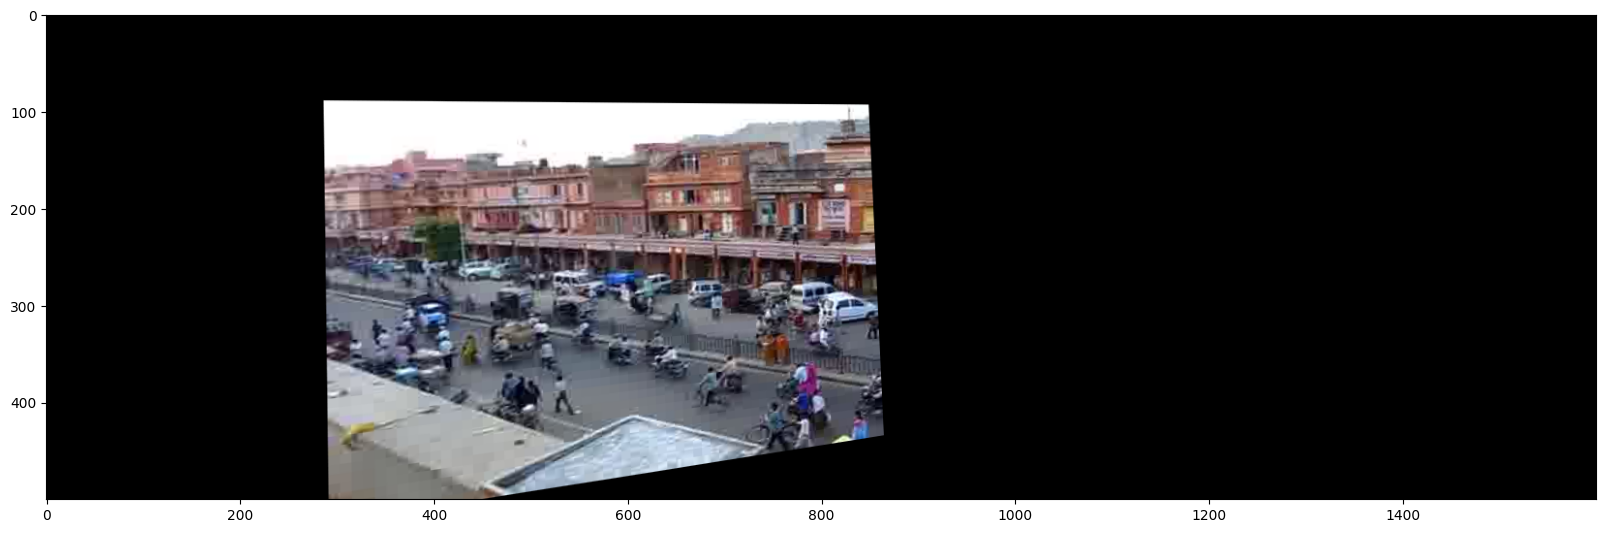

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(im_collect[199])

### Part 4: Create background panorama

Create a background panorama based on the result from Part 3.


In [ ]:
# TO DO part 4
projectedWidth = 1600
projectedHeight = 500
datadir="/content/drive/MyDrive/CS445/Project5/part3"
filesinfo = os.scandir(datadir)
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
total_im=np.zeros((900,projectedHeight,projectedWidth,3),dtype=np.float32)
filenames.sort()  # Ensure the order is correct

In [ ]:
bg_frame = np.zeros((projectedHeight, projectedWidth, 3), dtype=np.float32)

In [ ]:
for idx, file_i in enumerate(filenames):
    total_im[idx] = cv2.imread(file_i).astype('float32')

In [ ]:
for k in range(3):
    # Extract the channel across all frames
    channel_data = total_im[:, :, :, k]

    # mask out zeros because median of zeros would skew the background calculation
    masked_channel = np.ma.masked_equal(channel_data, 0)
    bg_frame[:, :, k] = np.ma.median(masked_channel, axis=0).filled(0)  # Fill masked values with 0 if any

bg_frame = bg_frame.astype(np.uint8)

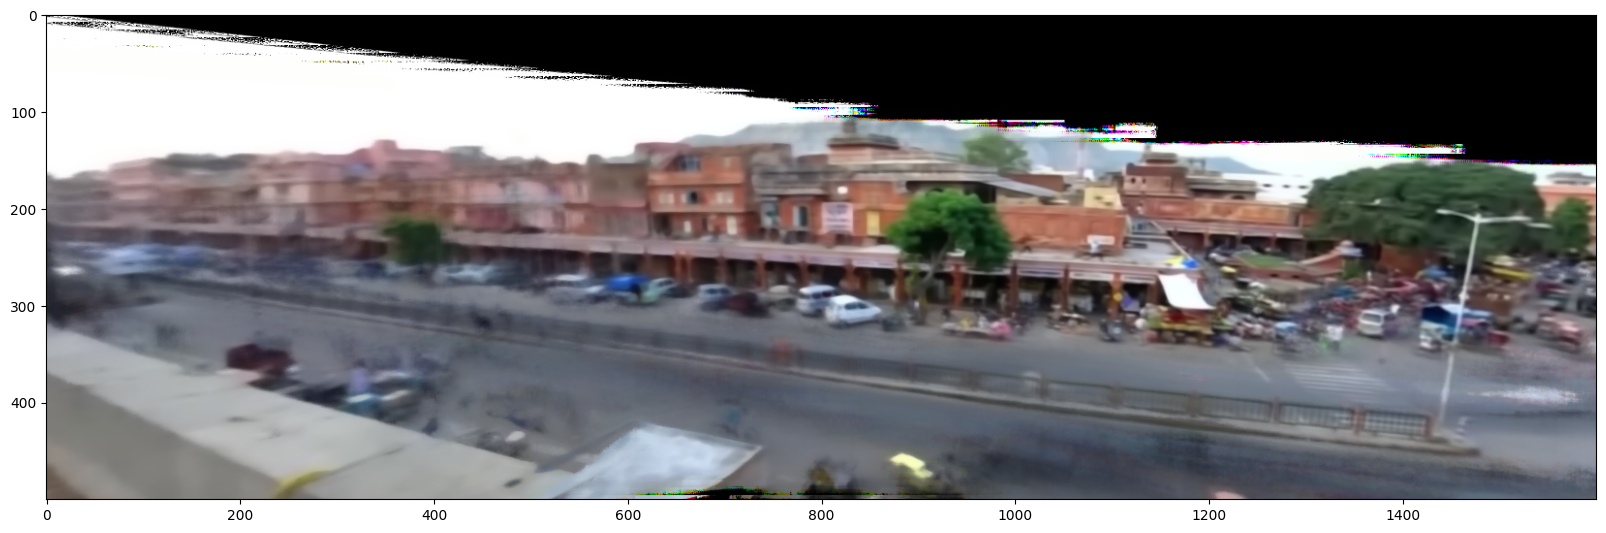

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(bg_frame[:,:,[2,1,0]])

### Part 5: Create background movie

Generate a movie that looks like the input movie but shows only background pixels. For each frame of the movie, you need to estimate a projection from the panorama to that frame. Your solution can use the background image you created in Part 4 and the per-frame homographies you created in Part 3.


In [ ]:
# TO DO part 5

Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])
H_transition = np.identity(3)

In [ ]:
im_bgcollect = []
for i in range(900):
    tmp = cv2.warpPerspective(bg_frame, np.linalg.pinv(np.dot(Tr, H_all[i])), (480, 360))   # frame dimenison:480*360
    im_bgcollect.append(tmp[:, :, [2, 1, 0]])  # from BGR to RGB


In [ ]:
final_bgcollect=[]
for i in range(900):
    tmp=cv2.warpPerspective(im_bgcollect[i], np.dot(Tr,H_all[i]), (projectedWidth, projectedHeight))
    final_bgcollect.append(tmp[:,:,[2,1,0]])

In [ ]:
datadir="/content/drive/MyDrive/CS445/Project5/part3"
length=(np.shape(final_bgcollect))[0]
for i in range(length):
    cv2.imwrite(datadir + "f{i}.jpg".format(i=i), final_bgcollect[i][:,:,:])
utils.imageFolder2mpeg(datadir , output_path='./output_video_bg.mpeg', fps=30.0)

In [ ]:
!ffmpeg -framerate 30 -i "/content/drive/MyDrive/CS445/Project5/part3f%d.jpg" -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p "/content/drive/MyDrive/CS445/Project5/output_bg_video.mp4"

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

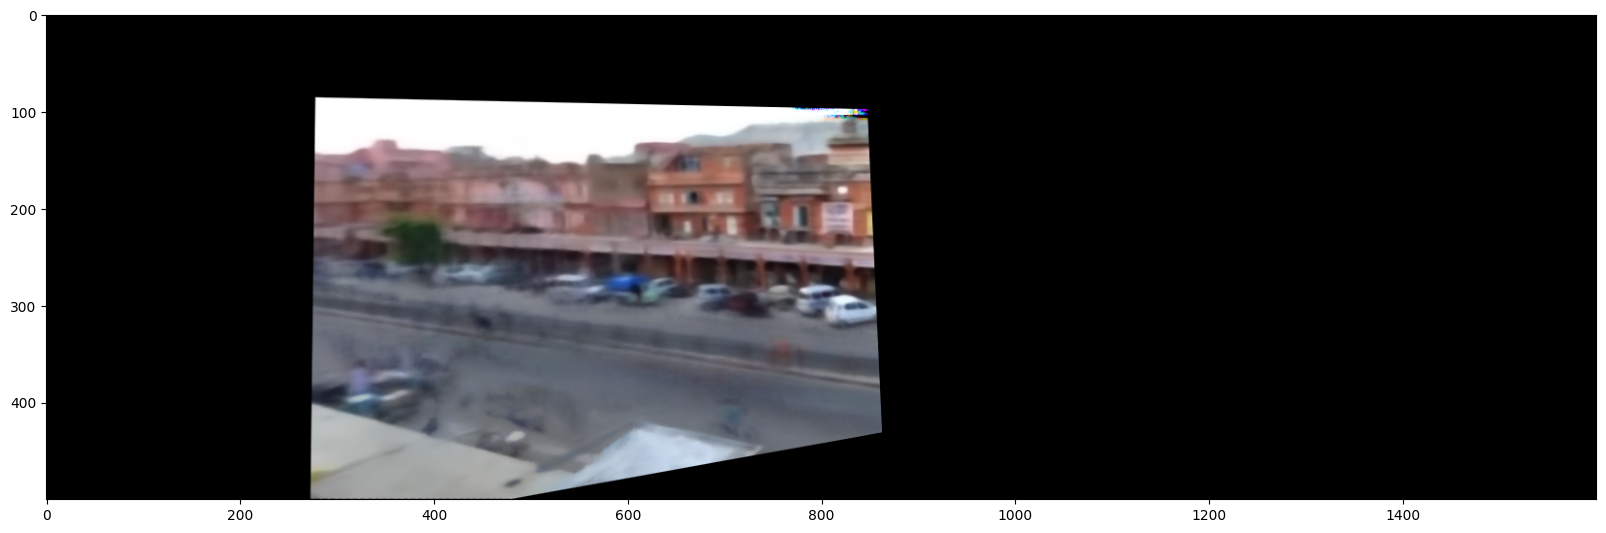

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(final_bgcollect[199][:,:,[2,1,0]])

### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that emphasizes or includes only foreground pixels.

In [ ]:
# TO DO part 6
fore_im=[]
for i in range(900):
    tmp=(im_collect[i]-final_bgcollect[i][:,:,[2,1,0]]).astype('uint8')
    fore_im.append(tmp)

In [ ]:
datadir="/content/drive/MyDrive/CS445/Project5/part6"
# length=(np.shape(fore_im))[0]
for i in range(900):
    cv2.imwrite(datadir + "f{i}.jpg".format(i=i), fore_im[i][:,:,:])
utils.imageFolder2mpeg(datadir , output_path='./output_video_fore.mpeg', fps=30.0)

In [ ]:
!ffmpeg -framerate 30 -i "/content/drive/MyDrive/CS445/Project5/part6f%d.jpg" -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p "/content/drive/MyDrive/CS445/Project5/output_fore_video.mp4"

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

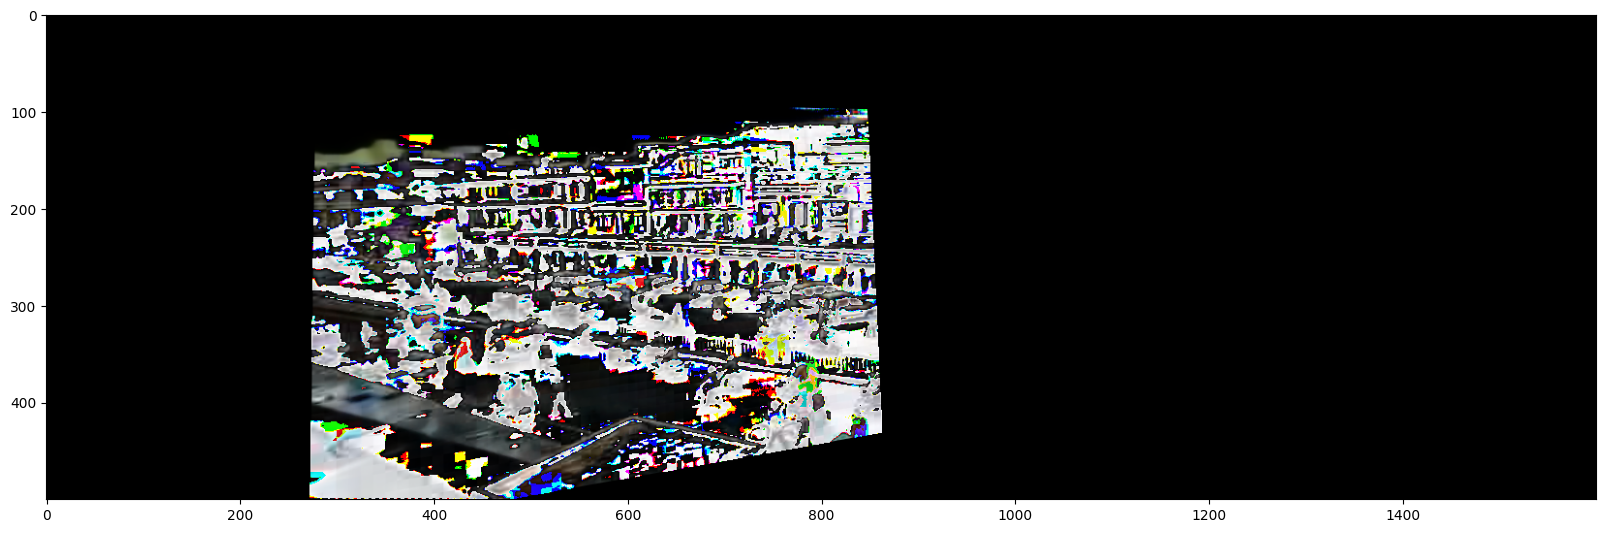

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(fore_im[199][:,:,[2,1,0]])

## Bells and whistles